# The General 

## Primary question of interest: Can you predict who was at fault?

### Secondary questions of interest:
- What Claim Group should the claim be routed to?
- Can we predict severity type (minor, moderate, major, life threatening, death)
- What was the cause of the loss?

In [1]:
import pandas as pd
import gensim
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from gensim.models.word2vec import Word2Vec, LineSentence
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
claims = pd.read_csv('/Users/rabram/Desktop/NSS/dq-9-finding-the-at-fault-party-with-claims-nlp-manta-rays/data/NSS_DS_data.thegeneral.csv')

In [19]:
df = pd.DataFrame(claims.FaultRatingName.value_counts()).reset_index()

In [26]:
df.head()
df.columns = ['FaultRatingName','count']

In [ ]:
plt.rcParams.update({'font.size': 10})
df.plot.barh('FaultRatingName','count', title = 'Fault Counts', figsize = (5,5), legend = False)
plt.xlabel('Number of Claims')
plt.ylabel('');

In [4]:
explore_claims = claims.drop_duplicates('CCCreateTime')

In [5]:
def fix_characters(text):
    text = re.sub(r'\*', '', text)
    text = re.sub(r'_', ' ', text)
    text = re.sub(r'\r', ' ', text)
    text = re.sub(r'\n', ' ', text) 
    text = re.sub('re ', 'rear ended', text) 
    text = text.lower()
    return text

explore_claims['ClaimLevelBody'] = explore_claims['ClaimLevelBody'].map(fix_characters)

In [229]:
explore_claims['AccidentDescription'] = explore_claims['AccidentDescription'].map(fix_characters)

In [254]:
explore_claims['DamageDescription'] = explore_claims['DamageDescription'].map(fix_characters)

## Start Modeling

### Tried CountVectorizer vs. TFIDF
### Tried NB Classifier vs. SGDClassifier

In [118]:
model = explore_claims

In [119]:
model = model.dropna()

In [120]:
X = model['ClaimLevelBody'].str.strip()
y = model['FaultRatingName']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 21)

In [122]:
def tokenizer(text):
    return re.findall(r'[a-z0-9]+', text.lower())

In [123]:
vect = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,2))
clf = SGDClassifier(loss='log', max_iter=100, tol=1e-6, random_state=42)

In [124]:
X_train_vect = vect.fit_transform(X_train)

In [125]:
X_test_vect = vect.transform(X_test)

--- gensim word2vec interlude ---

In [77]:
claim_list = explore_claims.DamageDescription.tolist()

In [78]:
doc = [str(claim_list).split()]

In [79]:
model = Word2Vec(doc, size=150,
        window=10,
        min_count=2,
        workers=10)

In [80]:
model.train(doc, total_examples=len(doc), epochs=10)

(100000, 14452590)

In [86]:
model.wv.most_similar(positive='vehicle')

[('had', 0.9995748400688171),
 ('car', 0.999489963054657),
 ('insured', 0.9994364976882935),
 ('pole', 0.9993816614151001),
 ('iv', 0.9993693232536316),
 ('cut', 0.9993181824684143),
 ('quitman', 0.9993139505386353),
 ('be', 0.9992308616638184),
 ('services', 0.9992300271987915),
 ('he', 0.9992241859436035)]

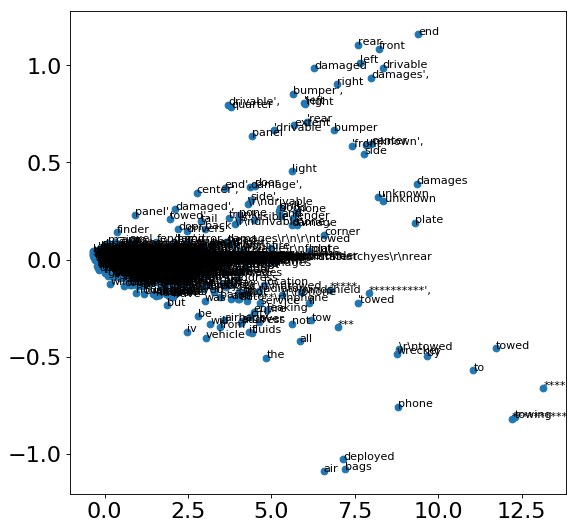

In [83]:
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

--- end gensim interlude -- 

In [126]:
clf.fit(X_train_vect, y_train)
y_pred = clf.predict(X_test_vect)
np.mean(y_test==y_pred)

0.8460943542150039

In [130]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8460943542150039

In [132]:
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.8460943542150039
                        precision    recall  f1-score   support

Comparative Negligence       0.57      0.20      0.30       911
         Fault unknown       0.00      0.00      0.00         3
      Insured at fault       0.87      0.96      0.91      9210
              No fault       0.47      0.29      0.36       716
  Other party at fault       0.84      0.83      0.84      3383

           avg / total       0.83      0.85      0.83     14223



In [128]:
# Get the class labels: class_labels
class_labels = clf.classes_

# Extract the features: feature_names
feature_names = vect.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(clf.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
feat_with_weights[-5:]

KeyboardInterrupt: 

In [ ]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [ ]:
class_labels = clf.classes_

In [ ]:
print_top10(vect, clf, class_labels)

## Best Model Thus Far

                        precision    recall  f1-score   support

Comparative Negligence       0.50      0.37      0.43       910
         Fault unknown       0.00      0.00      0.00         3
      Insured at fault       0.89      0.95      0.92      9245
              No fault       0.44      0.35      0.39       721
  Other party at fault       0.87      0.81      0.84      3344

           avg / total       0.84      0.85      0.84     14223

Comparative Negligence: however iv cv negligence decision lookout majority compneg comparative comp neg neg
Fault unknown: ped alexandria clmt us fx lessner pc pc to report insd
Insured at fault: liability adverse re cv single ended cv fol iv control into cv iv rear iv re when iv
No fault: insured stated shooting suspect lor donald a deer comp shot theft deer
Other party at fault: cv pulled umpd accepted liability cv re ended iv when cv fol cv re iv struck iv umbi

.8497504042747662

up to 0.8538986149194966 after replaced re with rear ended

# Predicting Severity Type

In [144]:
X = model['ClaimLevelBody'].str.strip()
y = model['SeverityTypeName']

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [146]:
def tokenizer(text):
    return re.findall(r'[a-z0-9]+', text.lower())

vect = CountVectorizer(tokenizer=tokenizer)
clf = SGDClassifier(loss='log', max_iter=100, tol=1e-6, random_state=42)

In [148]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [149]:
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
np.mean(y_test==y_pred)

0.6740490754411869

In [150]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [151]:
print_top10(tfidf, clf, class_labels)

Comparative Negligence: killed wrongful news funeral died fatal death deceased fatality estate
Fault unknown: torrie lybarger ped life tawanda montgomery fx icu coma pedestrian
Insured at fault: excess hospitalized ribs fractured uim broken hospital fx surgery sir
No fault: cov minor atc attry tol sorear ha lm claimant clamnt
Other party at fault: concussion office head used best wrist er law attorney purposes


In [152]:
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.6740490754411869
                                        precision    recall  f1-score   support

                                 Death       1.00      0.04      0.08       136
                      Life-threatening       0.00      0.00      0.00        34
Major (hospitalization 3+ days or ICU)       0.61      0.17      0.27       716
                                 Minor       0.69      0.98      0.81      9233
                              Moderate       0.48      0.11      0.18      4104

                           avg / total       0.63      0.67      0.59     14223



# Claim Group Analysis - What claim group should it go to?

In [133]:
explore_claims['ClaimGroup'].value_counts()

Cleveland Field Ops       9030
PIP                       8537
Tampa Field Ops           5143
Phoenix Casualty Ops      5130
Nashville Field Ops       4910
Nashville Casualty Ops    4213
Atlanta Casualty Ops      3568
Large Loss 2              3262
Cleveland Casualty Ops    3003
CCU                       3002
NARBI                     2779
Tampa Casualty Ops        2528
Atlanta Field Ops         2513
Large Loss 1              2396
Phoenix West Field Ops    2244
Albany Casualty Ops       1969
Total Loss                1680
Phoenix East Field Ops    1634
Claims Overflow           1530
Fast Track                1390
DMA Vendor                1121
Albany Field Ops          1095
Inbound Subrogation       887 
Recoveries                508 
Inactive                  449 
Specialty                 389 
Large Loss 3              319 
Non Claims                305 
Central SIU               264 
Claims QA                 195 
West Coast SIU            134 
TAG                       39  
Premium 

In [134]:
explore_claims['ClaimGroup_simple'] = pd.np.where(explore_claims.ClaimGroup.str.contains("Field Ops"), "Field Ops",
                   pd.np.where(explore_claims.ClaimGroup.str.contains("Casualty"), "Casualty Ops",
                   pd.np.where(explore_claims.ClaimGroup.str.contains("SIU"), "SIU", 
                               pd.np.where(explore_claims.ClaimGroup.str.contains("Loss"), "Loss", explore_claims.ClaimGroup))))

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [135]:
explore_claims.head()

ClaimID_RGEN  ExposureID_RGEN  \
0  10000         131005            
1  10001         131006            
2  10002         131007            
4  10004         131009            
6  10006         131011            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [136]:
explore_claims['ClaimGroup_simple'].value_counts()

Field Ops              26587
Casualty Ops           20411
PIP                    8537 
Loss                   7657 
CCU                    3002 
NARBI                  2779 
Claims Overflow        1530 
Fast Track             1390 
DMA Vendor             1121 
Inbound Subrogation    887  
Recoveries             508  
Inactive               449  
SIU                    406  
Specialty              389  
Non Claims             305  
Claims QA              195  
TAG                    39   
CCU Executive          1    
Dispatch               1    
Admin                  1    
Name: ClaimGroup_simple, dtype: int64

## Selected 6 largest claim groups after aggregating

In [137]:
explore_group = explore_claims.loc[(explore_claims.ClaimGroup_simple == 'Field Ops') |
                                  (explore_claims.ClaimGroup_simple == 'Casualty Ops') |
                                  (explore_claims.ClaimGroup_simple == 'PIP') |
                                  (explore_claims.ClaimGroup_simple == 'Loss') |
                                  (explore_claims.ClaimGroup_simple == 'CCU') |
                                  (explore_claims.ClaimGroup_simple == 'NARBI')]

In [138]:
explore_group['ClaimGroup_simple'].value_counts()

Field Ops       26587
Casualty Ops    20411
PIP             8537 
Loss            7657 
CCU             3002 
NARBI           2779 
Name: ClaimGroup_simple, dtype: int64

In [139]:
X = explore_group['ClaimLevelBody'].str.strip()
y = explore_group['ClaimGroup_simple']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [141]:
def tokenizer(text):
    return re.findall(r'[a-z0-9]+', text.lower())

vect = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,2))
clf = SGDClassifier(loss='log', max_iter=100, tol=1e-6, random_state=42)

tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.7)
nb_classifier = MultinomialNB(alpha = 0.002)

In [142]:
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

KeyboardInterrupt: 

In [101]:
#X_train_tfidf = tfidf.fit_transform(X_train)
#X_test_tfidf = tfidf.transform(X_test)

In [102]:
clf.fit(X_train_vect, y_train)
y_pred = clf.predict(X_test_vect)
np.mean(y_test==y_pred)

0.8117915824619981

In [143]:
print('Accuracy Score: 0.8117915824619981')

Accuracy Score: 0.8117915824619981


In [103]:
class_labels = clf.classes_

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [104]:
print_top10(vect, clf, class_labels)

CCU: ccu sol lit emailed plntf served pl pc suit revd
Casualty Ops: complete bie rept change of bie pc to pc attny ird rec clamnt eh
Field Ops: flags lm to ebi to ih closing ih called the for cb closing file expo
Loss: atc atty from atty i got dismissal ob call recommendations i called rcvd the only executed
NARBI: thanked wclmnt was able cnt placed phone call to lmtcb placed phone pat lmfcb
PIP: claim to medpay transfer transferring dilley aao oc ime pip sup to pip


In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         CCU       0.84      0.67      0.74      1012
Casualty Ops       0.86      0.86      0.86      6702
   Field Ops       0.81      0.86      0.84      8782
        Loss       0.73      0.80      0.76      2539
       NARBI       0.82      0.56      0.67       905
         PIP       0.76      0.68      0.72      2822

 avg / total       0.81      0.81      0.81     22762



## EDA - ClaimLevelBody length

In [196]:
explore_claims.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName,split,ClaimGroup_simple
0,10000,131005,reviewed coverage sc rated policy and loss e...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.9100000,2015-04-29 11:25:18.3190000,South Carolina,train,Field Ops
1,10001,131006,c dol tol pm venue fl ...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.1590000,2015-07-06 08:26:47.5350000,Florida,train,Field Ops
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida,train,Field Ops
4,10004,131009,adjuster out of office reassigned adjuster ou...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida,train,Fast Track
6,10006,131011,clear siu claim cov cov issue dol win ...,none none demand recd for clmt brockman\r\nlet...,cv was going through the traffic light and iv ...,back pain,front right side damaged head lights hood is d...,Minor,Atlanta Casualty Ops,Insured at fault,Collision in an intersection,2015-03-13 10:36:54.4740000,2016-05-23 13:07:36.1840000,South Carolina,train,Casualty Ops


In [203]:
explore_claims['lengths'] = explore_claims['ClaimLevelBody'].map(len)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [205]:
explore_claims.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName,split,ClaimGroup_simple,lengths
0,10000,131005,reviewed coverage sc rated policy and loss e...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.9100000,2015-04-29 11:25:18.3190000,South Carolina,train,Field Ops,24125
1,10001,131006,c dol tol pm venue fl ...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.1590000,2015-07-06 08:26:47.5350000,Florida,train,Field Ops,9824
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida,train,Field Ops,13181
4,10004,131009,adjuster out of office reassigned adjuster ou...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida,train,Fast Track,21204
6,10006,131011,clear siu claim cov cov issue dol win ...,none none demand recd for clmt brockman\r\nlet...,cv was going through the traffic light and iv ...,back pain,front right side damaged head lights hood is d...,Minor,Atlanta Casualty Ops,Insured at fault,Collision in an intersection,2015-03-13 10:36:54.4740000,2016-05-23 13:07:36.1840000,South Carolina,train,Casualty Ops,31579


In [208]:
explore_claims.groupby('FaultRatingName')['lengths'].mean()

FaultRatingName
Comparative Negligence    20104.077643
Fault unknown              9941.502831
Insured at fault          14572.777822
No fault                   9121.473555
Other party at fault      12464.426827
Name: lengths, dtype: float64

## Convert to Binary - either the insured is at fault or not

In [106]:
explore_claims['Fault_binary'] = pd.np.where(explore_claims.FaultRatingName.str.contains("Insured at fault"), "Insured at fault", "Other at fault")

In [107]:
X = explore_claims['ClaimLevelBody'].str.strip()
y = explore_claims['Fault_binary']

In [108]:
y.value_counts()

Insured at fault    47544
Other at fault      28651
Name: Fault_binary, dtype: int64

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [110]:
y_train.value_counts()

Insured at fault    31846
Other at fault      19204
Name: Fault_binary, dtype: int64

In [111]:
def tokenizer(text):
    return re.findall(r'[a-z0-9]+', text.lower())

vect = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,2))
clf = SGDClassifier(loss='log', max_iter=100, tol=1e-6, random_state=42)
tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.7)
nb_classifier = MultinomialNB(alpha = 0.002)

In [112]:
X_train_vect = vect.fit_transform(X_train)

In [113]:
X_test_vect = vect.transform(X_test)

In [114]:
clf.fit(X_train_vect, y_train)
y_pred = clf.predict(X_test_vect)
np.mean(y_test==y_pred)

0.8727778882481607

In [115]:
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

Insured at fault       0.90      0.89      0.90     15698
  Other at fault       0.83      0.84      0.83      9447

     avg / total       0.87      0.87      0.87     25145



In [116]:
# Get the class labels: class_labels
class_labels = clf.classes_

# Extract the features: feature_names
feature_names = vect.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(clf.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
feat_with_weights[-5:]

[(17.46850080337592, 'umbi'),
 (18.226136756958326, 'struck iv'),
 (18.583854038892202, 'comp neg'),
 (18.827830752258897, 'liability denial'),
 (22.611545768395725, 'cv rear')]

In [117]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [273]:
class_labels = clf.classes_

In [257]:
print_top10(vect, clf, class_labels)

Insured at fault: impacts into iv for of umbi struck iv comp neg liability denial re iv ended iv cv re


IndexError: index 1 is out of bounds for axis 0 with size 1